## This notebook has been uploaded to GitHub
### https://github.com/silverboris/DataScienceClass/blob/master/FP2_Boris_Serebrinskiy_EDA.ipynb



## MS Data Science Class
### Final Project, Part 2. Exploratory Data Analysis
### Author: Boris Serebrinskiy
### Date: Nov 11-19, 2018

### Project Name: Predicting cost of solar panel installations based on system size, progress in solar panel development, and changes in economic incentives

### Problem Statement: this essentially matches Project Name - What are the effects of technological progress and economical factors on costs of solar energy systems?

### Hypothesis: Solar energy costs will continue to decrease. They primarely depend on efficiency of the solar panels, size of the systems, and economic incentives. 


We will be using the following datasets:
DS1. register of solar installations in USA, 2000-2017 from https://emp.lbl.gov/tracking-the-sun/
DS2. Detailed State Data Electric Rates from https://www.eia.gov/electricity/data/state/

Full DS1 set is over 1.5MM rows and contains data for over 15 years. We will randomly select 10000 solar energy installations and save them into a separate file. This will create an unbiased data set. 




#### Exploratory Data Analysis plan:
The plan is to randomly extract data from a very large population, clean it up by removing zero data, obvious outliers, and any other information that appears as noise. Once data is clean, we will enrich it with a a couple of features like CostPerKW and IncentivePct. Using scatter plot, line plot, etc we will attempt to visually identify trends and relationships within data. We will check for data distribution using histograhms. We will also do a light analysis for time series using line plots.

#### Target variable (outcome) - we consider Price of the system to be the target, but CostPerKW is also an interesting candidate.
#### Size, efficiency and IncentivePct (and CostPerKW?) are considered predictors
#### Finally we will store the clean data set into a new file to allow separating EDA notebook from the next phase of Final Project work.

In [1]:
#import packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from string import ascii_letters

sns.set()

import linecache
import random
import csv



In [2]:
# Global variables
DATA_FILE = 'solar_random_dataset.csv'

# set to True - CAREFUL - if you want to get new random data file, this will override the old one
REGENERATE_RANDOM_FILE = False



### Solar installation data is split into 2 files
### But the first file is mostly California, so we will skip it to avoid bias in data
### Since loading directly to pandas would take very long time and we may run out of memory
### instead we will open file, scan it and randomly select rows from it. 



In [3]:


def get_random_lines_from_file(filename, linestoget, alwaysgetheader):
    linestoreturn = []

    with open(filename) as f:
        linecount = sum(1 for line in f)
        print("found " + str(linecount) + " lines in file " + filename)
    
    if alwaysgetheader:
      linestoreturn.append(linecache.getline(filename,1))
        
    for i in random.sample(range(linecount),linestoget):
        linestoreturn.append(linecache.getline(filename, i))
  
    return linestoreturn


# REGENERATE_RANDOM_FILE is set to False, only make it True if you want to redo random file

if REGENERATE_RANDOM_FILE:
    randomlines = []
    randomlines = get_random_lines_from_file('TrackingtheSun2018_Data_2.csv',20000,True)
#    randomlines.extend(get_random_lines_from_file('TrackingtheSun2018_Data_2.csv',5000,False))

#print(len(randomlines))
#randomlines

    with open(DATA_FILE, 'w') as myfile:
        for l in randomlines:
            myfile.write(l)
        print("Wrote " + str(len(randomlines)) + " to " + DATA_FILE )
else:
    print('We are NOT regenerating random solar file!')
            
            
with open(DATA_FILE, 'r') as myfile:
    linecount = sum(1 for line in myfile)
    print("found " + str(linecount) + " lines in file " + DATA_FILE)




We are NOT regenerating random solar file!
found 20001 lines in file solar_random_dataset.csv


In [4]:
import pandas as pd

df = pd.read_csv(DATA_FILE)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
SystemID                                  20000 non-null object
InstallationDate                          20000 non-null object
SystemSize                                20000 non-null float64
TotalInstalledPrice                       20000 non-null float64
SalesTaxCost                              20000 non-null float64
RebateOrGrant                             20000 non-null float64
PerformanceBasedIncentiveAnnualPayment    20000 non-null float64
PerformanceBasedIncentivesDuration        20000 non-null int64
CustomerSegment                           20000 non-null object
ZipCode                                   20000 non-null int64
State                                     20000 non-null object
ModuleEfficiency                          20000 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.8+ MB


## Let's proceed with data clean up
## In this data set value of "-9999" represents missing value

## Steps to clean the data:
### Relabel long column names 
### Remove rows with outliers 
-  price should be within 10k-100k
-  system size - 1-20Kw
-  panel efficiency > 0.1 (10%)

### Replace missing values for tax, rebate, performance incentives with a zero, set type to Residential

### convert zip code into a string, convert date into a proper datetime type


In [6]:
# making a copy of the original dataset
df_clean = df.copy()

# relabeling long column names and fixing data types
df_clean = df_clean.rename(columns={"PerformanceBasedIncentiveAnnualPayment":"PBIAnnual", "PerformanceBasedIncentivesDuration": "PBIDuration", \
                  "InstallationDate":"date", "SystemSize": "Size", "TotalInstalledPrice": "price", "SalesTaxCost": "tax", \
                  "CustomerSegment":"type","ZipCode":"zip","ModuleEfficiency" : "efficiency"})

# removing bad data - no price, and outliers - very large and tiny installations
df_clean.fillna(0)
df_clean = df_clean[df_clean.price > 10000]
df_clean = df_clean[df_clean.price < 100000]
df_clean = df_clean[df_clean.Size < 20]
df_clean = df_clean[df_clean.Size > 1.]
df_clean = df_clean[df_clean.efficiency > 0.10]


# if tax is -9999 make it 0
df_clean["tax"] = df_clean.apply(lambda row : (0 if row.tax == -9999 else row.tax), axis=1)
df_clean["RebateOrGrant"] = df_clean.apply(lambda row : (0 if row.RebateOrGrant == -9999 else row.RebateOrGrant), axis=1)
df_clean["PBIAnnual"] = df_clean.apply(lambda row : (0 if row.PBIAnnual == -9999 else row.PBIAnnual), axis=1)

df_clean["PBIDuration"] = df_clean.apply(lambda row : (0 if row.PBIDuration == -9999 else row.PBIDuration), axis=1)

df_clean["type"] = df_clean.apply(lambda row : ("RES" if row.type == "-9999" else row.type), axis=1)

#turning zip to string
df_clean["zip"] = df_clean.apply(lambda row : str(row.zip), axis=1)
# date to real datetime
df_clean["date"] = pd.to_datetime(df_clean.date)

df_clean.set_index(df_clean.date, inplace=True)


In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9491 entries, 2014-06-18 to 2017-06-02
Data columns (total 12 columns):
SystemID         9491 non-null object
date             9491 non-null datetime64[ns]
Size             9491 non-null float64
price            9491 non-null float64
tax              9491 non-null float64
RebateOrGrant    9491 non-null float64
PBIAnnual        9491 non-null float64
PBIDuration      9491 non-null int64
type             9491 non-null object
zip              9491 non-null object
State            9491 non-null object
efficiency       9491 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 963.9+ KB


In [8]:
df_clean.describe()

,Size,price,tax,RebateOrGrant,PBIAnnual,PBIDuration,efficiency
count,9491.000000,9491.000000,9491.000000,9491.000000,9491.000000,9491.000000,9491.000000
mean,6.686347,30864.283533,369.835853,2870.824058,11.904585,0.055316,0.169170
std,3.044833,14302.370473,526.824143,4448.481061,167.441541,0.721925,0.019427
min,1.077076,10003.000000,0.000000,0.000000,0.000000,0.000000,0.102778
25%,4.500000,20497.000000,0.000000,0.000000,0.000000,0.000000,0.157407
50%,6.110000,27906.000000,0.000000,1250.000000,0.000000,0.000000,0.164516
75%,8.320000,37933.000000,604.606177,3840.000000,0.000000,0.000000,0.181452
max,19.980000,99000.000000,7545.041252,50400.000000,4146.220000,10.000000,0.220859


### Looks like we have removed about half the rows, so we need to make sure we got enough random data 
### Let's see how data looks:

In [9]:
df_clean.head()

,SystemID,date,Size,price,tax,RebateOrGrant,PBIAnnual,PBIDuration,type,zip,State,efficiency
date,,,,,,,,,,,,
2014-06-18,MA_DOER_CEC_36409,2014-06-18,5.250000,24727.5,0.000000,2000.0,0.0,0,RES,2721,MA,0.155280
2014-01-24,CA_LADWP_11890,2014-01-24,11.347732,71148.0,1289.214212,11915.0,0.0,0,RES,91352,CA,0.188957
2010-12-09,CA_SMUD_1074,2010-12-09,4.700000,18000.0,1319.266331,0.0,1788.6,5,RES,95608,CA,0.144172
2015-12-30,NY_NYSERDA_78622,2015-12-30,4.510000,25318.1,0.000000,1734.0,0.0,0,RES,10977,NY,0.165766
2012-07-09,CA_LADWP_5214,2012-07-09,1.077076,12000.0,141.460037,1745.0,0.0,0,RES,90034,CA,0.161290


## Distribution of data by Customer Type, as we can see most data is residential

In [10]:
df_clean.groupby(by="type").count()

,SystemID,date,Size,price,tax,RebateOrGrant,PBIAnnual,PBIDuration,zip,State,efficiency
type,,,,,,,,,,,
COM,52,52,52,52,52,52,52,52,52,52,52
GOV,1,1,1,1,1,1,1,1,1,1,1
NON-PROFIT,52,52,52,52,52,52,52,52,52,52,52
NON-RES,75,75,75,75,75,75,75,75,75,75,75
RES,9307,9307,9307,9307,9307,9307,9307,9307,9307,9307,9307
SCHOOL,4,4,4,4,4,4,4,4,4,4,4


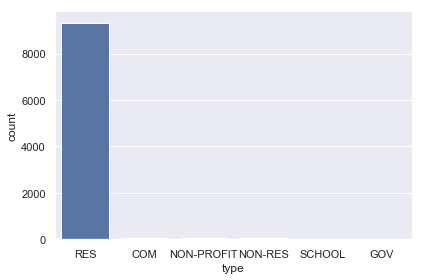

In [11]:
sns.countplot(x='type', data=df_clean)
sns.despine()
plt.tight_layout()

## Since most of the data is residential, we will remove all other data to avoid noise from commercial and government installations

In [12]:
df_clean = df_clean[df_clean.type == 'RES']

## Distribution of data by State

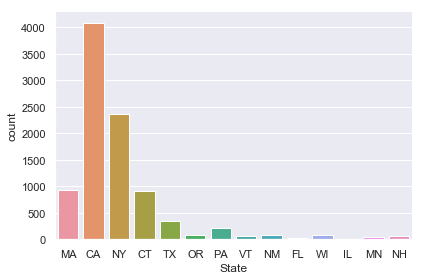

In [13]:
sns.countplot(x='State', data=df_clean)
sns.despine()
plt.tight_layout()

## Data looks reasonably well represented across largest states. Note how CA, NY are the largest producers


# Add Cost Per KW to our data - add costs together and divide by the system size. If cost per KW ends up being over 10k it is a sign of a big outlier, so we will cap it at 10k per KW

In [14]:

df_clean["CostPerKW"] = df_clean.apply(lambda row : ( (row.price-row.RebateOrGrant+row.tax-row.PBIAnnual*row.PBIDuration)/row.Size), axis=1)

df_clean["CostPerKW"] = df_clean.apply(lambda row : (10000 if row.CostPerKW > 10000 else row.CostPerKW), axis=1)



## Render distribution plot for CostPerKW - data appears to be normally distibuted

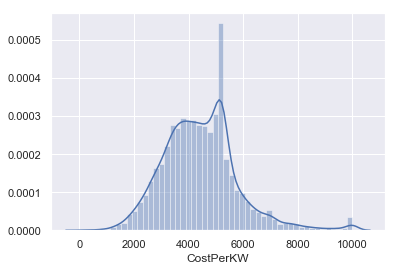

In [15]:

sns.distplot(df_clean.CostPerKW)

## Render distribution plot for Price - data appears to be normally distibuted but with a long tail

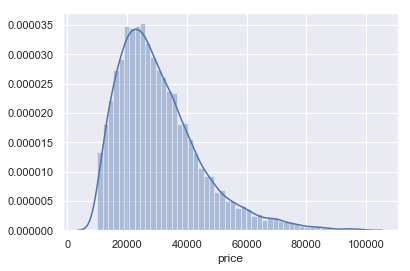

In [16]:
sns.distplot(df_clean.price)

## Let's convert all incentives, tax, rebates into a single column relative to price

In [17]:
df_clean["IncentivePct"] = \
    df_clean.apply(lambda row : ( (row.RebateOrGrant-row.tax+row.PBIAnnual*row.PBIDuration)/row.price), axis=1)



## Remove columns that have been used for CostPerKW and IncentivePct

In [18]:
df_clean = df_clean[["date","Size","price","efficiency","CostPerKW","IncentivePct","State","zip"]]



In [19]:
df_clean.describe()

,Size,price,efficiency,CostPerKW,IncentivePct
count,9307.000000,9307.000000,9307.000000,9307.000000,9307.000000
mean,6.642389,30635.634608,0.169330,4428.763620,0.077312
std,2.991604,14019.929454,0.019420,1368.387141,0.120108
min,1.077076,10003.000000,0.102778,153.514228,-0.078681
25%,4.490564,20465.500000,0.157407,3500.000000,0.000000
50%,6.090000,27760.000000,0.164516,4368.726163,0.035714
75%,8.280000,37646.500000,0.181452,5215.018022,0.130348
max,19.750000,99000.000000,0.220859,10000.000000,0.958925


### Final Data Dictionary
| Variable | Description | Data Type | Type of Variable |
| --- | --- | --- |
| data | Date of the installation | datetime | discrete |
| Size | Size of the system, kilowatts | float | contiuous |
| price | Price of the system | float | contiuous |
| efficiency | solar panel efficiency, percent solar to electric conversion | float | continious |
| CostPerKW | Cost after incentive, per KW | float | continious |
| IncentivePct | percentage customer received back | float | continious |
| State | US state 2 letter abbreviation | string | geographical |
| zip | US zip code 5 digit | string | geographical |














## Print correlation coefficients

In [20]:
df_clean.corr()

,Size,price,efficiency,CostPerKW,IncentivePct
Size,1.000000,0.773327,0.136470,-0.330242,0.001065
price,0.773327,1.000000,0.024801,0.211347,0.095390
efficiency,0.136470,0.024801,1.000000,-0.094252,-0.248038
CostPerKW,-0.330242,0.211347,-0.094252,1.000000,-0.276740
IncentivePct,0.001065,0.095390,-0.248038,-0.276740,1.000000


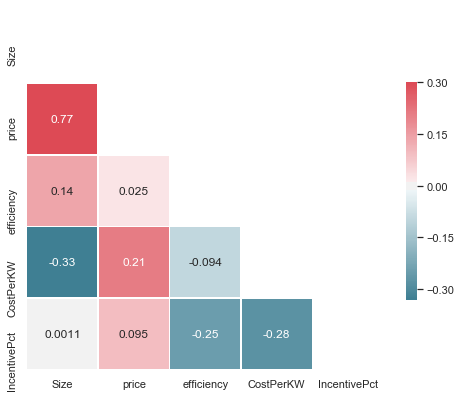

In [34]:
sns.set(style="white")


# Compute the correlation matrix
corr = df_clean.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

## What do we see in the data:
### CostPerKW is -0.28 correlated with IncentivePct (more incentive means less costly installations)
### Efficiency is -0.09 correlated with CostPerKW (higher efficienct means less costly installations)
### Size is also negatively (-0.33) correlated with CostPerKW
### Size is clearly highly correlated with Price (0.77) but it is not 1, meaning there is improvement in Price per KW (CostPerKW) as systems get larger

## Plot scatter by Size/Price, IncentivePct/CostPerKW, etc.

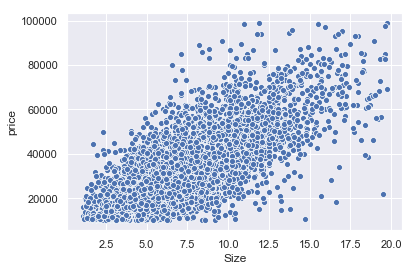

In [21]:

sns.scatterplot(x="Size", y="price", data=df_clean)


## We can see a fairly linear depenndency between Size and Price of a system, as expected, but what about Size and CostPerKW, or IncentivePct and CostPerKW?

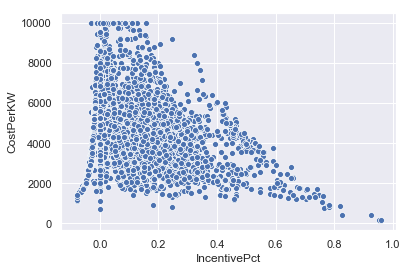

In [22]:
sns.scatterplot(x="IncentivePct", y="CostPerKW", data=df_clean)

## Higher incentive percentage lowers CostPerKW, so does a larger system size 

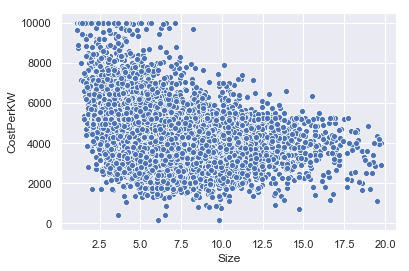

In [23]:
sns.scatterplot(x="Size", y="CostPerKW", data=df_clean)

## Plot efficiency over time, there is a clear upward trend

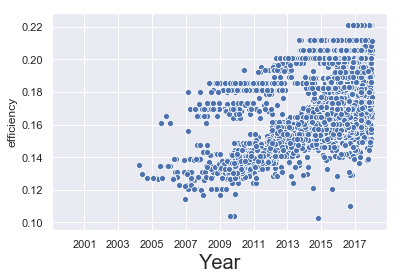

In [24]:
sns.scatterplot(data=df_clean,x="date",y="efficiency", x_bins=10) 
plt.xlabel('Year', fontsize=20); 

## Render CostPerKW line graph over time, we see a down trend, but there is a lot of noise in the data

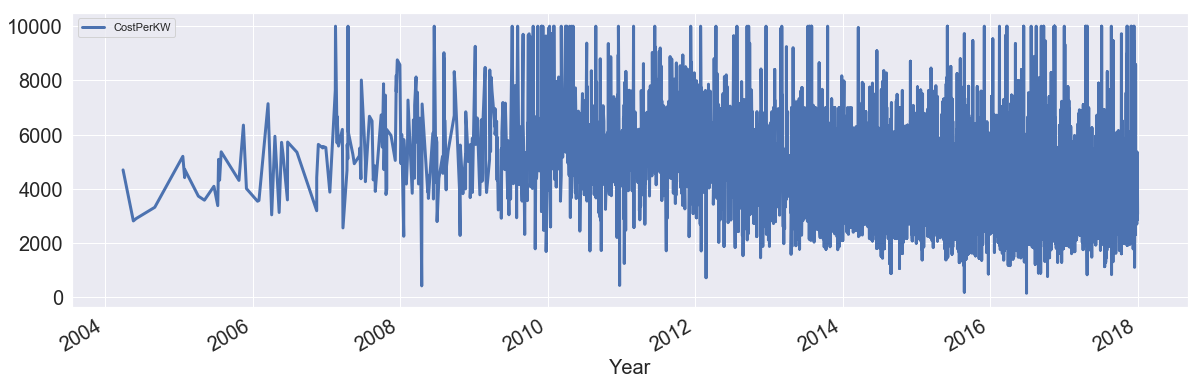

In [25]:
df_clean.plot.line(x="date",y="CostPerKW", figsize=(20,6), linewidth=3, fontsize=20) 

plt.xlabel('Year', fontsize=20); 


## EDA Conclusions
-  We found potentital correlation between efficiency of solar panels, size of the systems, and incentives
-  There is significant noise in Price and CostPerKW data, but there are also noticeable trends
-  Efficiency of the panels grows year over year
-  We have yet to introduce electric rates into the data, we will do it in the next phase of the project

## Finally, store clean dataset to a new file

In [27]:
df_clean.to_csv("solar_clean_data.csv")